# AR(2) model with variational inference

In [28]:
import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
import jax.random as random

from gaul import advi

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (11, 7)

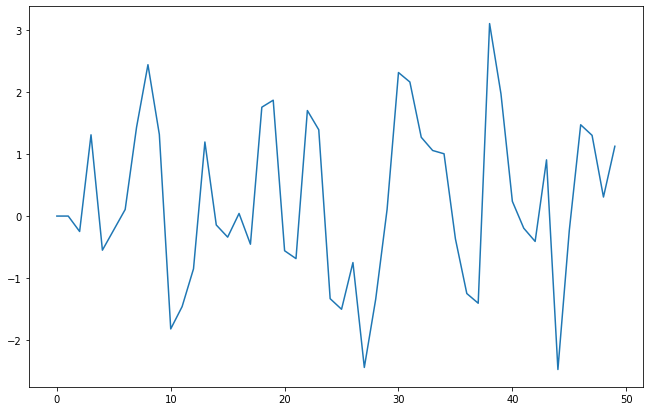

In [22]:
n = 50
beta1 = 0.5
beta2 = -0.3
sigma = 1.3

y = jnp.zeros(n)
for i in range(2, n):
    y = y.at[i].set(beta1 * y[i - 1] + beta2 * y[i - 2] + sigma * random.normal(random.PRNGKey(i)))

plt.plot(y)

In [23]:
def ln_posterior(params, data):
    target = 0
    
    target += stats.norm.logpdf(params['beta1'], 0., 1.)
    target += stats.norm.logpdf(params['beta2'], 0., 1.)
    target += stats.expon.logpdf(jnp.exp(params['logstd']), scale=1.)
    
    target += stats.norm.logpdf(
        params['beta1'] * data['y'][1:-1] + params['beta2'] * data['y'][2:],
        data['y'][:-2], 
        jnp.exp(params['logstd'])
    ).sum()

    return target.sum()

In [24]:
params = dict(
    beta1=jnp.zeros(1),
    beta2 = jnp.zeros(1),
    logstd=jnp.zeros(1),
)

data = dict(
    y=y,
)

In [25]:
samples = advi.sample(
    ln_posterior,
    params,
    lr=0.2,
    data=data
)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [26]:
samples = jax.tree_util.tree_map(lambda x: x.reshape(-1), samples)

<AxesSubplot:ylabel='Density'>

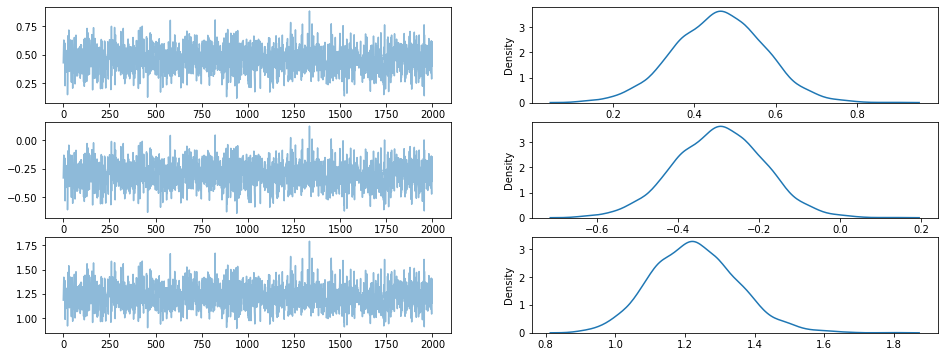

In [29]:
fig, ax = plt.subplots(3, 2, figsize=(16, 6))

ax[0,0].plot(samples['beta1'], alpha=0.5)
ax[1,0].plot(samples['beta2'], alpha=0.5)
ax[2,0].plot(jnp.exp(samples['logstd']), alpha=0.5)

sns.kdeplot(samples['beta1'], ax=ax[0,1])
sns.kdeplot(samples['beta2'], ax=ax[1,1])
sns.kdeplot(jnp.exp(samples['logstd']), ax=ax[2,1])

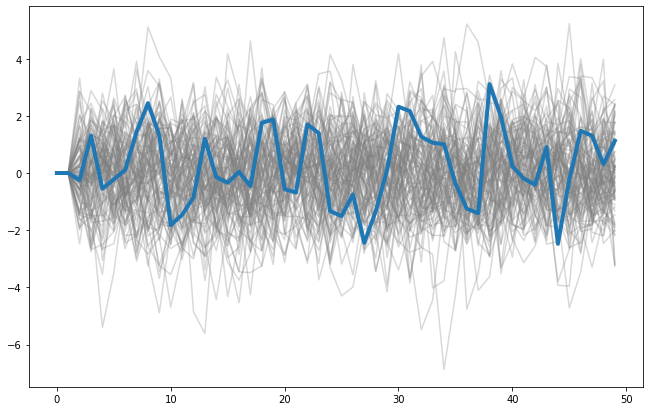

In [30]:
def sim_ar2(beta1, beta2, sigma, rng):
    ysim = jnp.zeros(n)
    for i in range(2, n):
        rng, subkey = random.split(rng)
        ysim = ysim.at[i].set(beta1 * ysim[i - 1] + beta2 * ysim[i - 2] + sigma * random.normal(subkey))
    return ysim

ysim = jax.vmap(sim_ar2)(
    samples['beta1'], 
    samples['beta2'], 
    jnp.exp(samples['logstd']), 
    random.split(random.PRNGKey(0), 2000)
)

for i in range(100):
    plt.plot(ysim[i], c='grey', alpha=0.3)
plt.plot(y, lw=4)